# Transformer
![](https://transformers.run/assets/img/attention/transformer.jpeg)

注意力机制

In [114]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# def scaled_dot_product_attention(query, key, value, mask=None):
#     d_k = query.size(-1) # 获取查询向量的维度
#     scores = torch.matmul(query, key.transpose(-2, -1)) / torch.sqrt(torch.tensor(d_k, dtype=torch.float32))
#     if mask is not None:
#         scores = scores.masked_fill(mask == 0, float('-inf'))
#     weights = F.softmax(scores, dim=-1)
#     output = torch.matmul(weights, value)
#     return output, weights
def scaled_dot_product_attention(Q, K, V, mask=None):
    score = torch.matmul(Q, K.transpose(-2, -1))

    d_k = K.size(-1)
    
    # scale: keep dtype/device consistent with inputs
    scores = score / (d_k ** 0.5)

    if mask is not None:
        mask = mask.to(device=scores.device)
        scores = scores.masked_fill(mask == 0, torch.finfo(scores.dtype).min)

    # softmax over key dimension so each query row sums to 1
    weights = F.softmax(scores, dim=-1)

    attention = torch.matmul(weights, V)

    return attention, weights

query = torch.rand(2, 4, 8)  # (batch_size, seq_len, d_k)
key = torch.rand(2, 4, 8)    # (batch_size, seq_len, d_k)
value = torch.rand(2, 4, 8)  # (batch_size, seq_len, d_v)
output, weights = scaled_dot_product_attention(query, key, value)
print("Output:", output)

Output: tensor([[[0.1694, 0.6572, 0.6449, 0.2534, 0.5150, 0.3588, 0.4359, 0.4889],
         [0.1666, 0.6529, 0.6365, 0.2556, 0.4973, 0.3540, 0.4264, 0.4927],
         [0.1648, 0.6466, 0.6299, 0.2549, 0.4829, 0.3531, 0.4194, 0.4935],
         [0.1730, 0.6535, 0.6382, 0.2504, 0.5099, 0.3437, 0.4349, 0.4999]],

        [[0.5045, 0.3519, 0.3106, 0.5937, 0.5465, 0.4610, 0.5317, 0.3809],
         [0.5174, 0.3765, 0.3003, 0.6102, 0.5303, 0.4863, 0.5371, 0.3581],
         [0.5130, 0.3584, 0.3052, 0.6055, 0.5367, 0.4682, 0.5338, 0.3773],
         [0.5015, 0.3683, 0.3120, 0.5913, 0.5534, 0.4749, 0.5321, 0.3637]]])


# 位置编码 Positional Encoding
1. 位置不变性问题 

注意力机制本身是位置不变的：如果打乱输入序列的顺序，注意力权重会相应变化，但计算方式不变。

对于语言来说，词序至关重要。“猫吃老鼠”和“老鼠吃猫”意思完全不一样。

解决方案：显式地向输入添加位置信息。

2. 正弦位置编码 

Vaswani等人于2017年提出使用正弦和余弦函数生成位置编码：

$$PE_{pos, 2i} = sin(\frac{pos}{10000^{\frac{2i}{d_{model}}}})$$

$$PE_{pos, 2i+1} = cos(\frac{pos}{10000^{\frac{2i}{d_{model}}}})$$

* pos: 位置索引

* i: 维度索引

* $d_{model}$: 模型维度

为什么选择正余弦函数？

1. 有界性：sin 和 cos 的值域为[-1, 1]，不会随位置增长而爆炸

2. 相对位置的线性表示： 对于任意固定偏移 k ，存在线性变换 $M_k$ 使得：
$$
PE_{pos+k} = M_k \cdot PE_{pos}
$$

这是因为三角函数的和角公式：

$$
sin(a+b) = sin(a)cos(b) + cos(a)sin(b) \\
cos(a+b) = cos(a)cos(b) - sin(a)sin(b)
$$

1. 多尺度表示：不同维度使用不同频率，低维度变化快，捕获局部位置，高维度变化慢，捕获全局位置

In [115]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000, dropout=0.1):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros((1, max_len, d_model)) # shape: (1, max_len, d_model)
        position = torch.arange(0,max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, :, 0::2] = torch.sin(position * div_term) # 偶数位置使用正弦函数
        pe[:, :, 1::2] = torch.cos(position * div_term) # 奇数位置使用余弦函数
        # pe = pe.unsqueeze(1) # 增加一个维度以匹配输入的形状
        self.register_buffer('pe', pe)


    def forward(self, x):
        # x = x + self.pe[:, :x.size(0), :]
        x = x + self.pe[:, :x.shape[1], :]  # 修改此行以确保形状匹配
        return self.dropout(x)
        # return x

In [116]:
x = torch.randn((10, 32, 512))  # (batch_size, seq_len, d_model)
print("Input shape:", x.shape)
print("Input size:", x.size())
pos_encoder = PositionalEncoding(d_model=512)
print(pos_encoder(x).shape)  # 输出: torch.Size([10, 32, 512])

Input shape: torch.Size([10, 32, 512])
Input size: torch.Size([10, 32, 512])
torch.Size([10, 32, 512])


Self-Attention 的优势：
与CNN的局部感受野和RNN的顺序传递不同，Self-Attention可以在单层内建立任意两个位置之间的直接连接。

路径长度对比：
* RNN: O(n) - 信息需要逐步传递
* CNN: O(log_k n) - 需要多层堆叠
* Self-Attention: O(1) - 直接连接

In [117]:
import torch
import torch.nn as nn
import math

class SelfAttention(nn.Module):
    def __init__(self, d_model, d_k, d_v):
        """
            初始化Self-Attention层
        
        :param self: Description
        :param d_moel: Description
        :param d_k: Description
        :param d_v: Description
        """
        super(SelfAttention, self).__init__()
        self.d_model = d_model
        self.d_k = d_k
        self.d_v = d_v

        # 初始化权重矩阵
        # scale = math.sqrt(2.0 / (d_model + d_k))
        # self.W_Q = torch.randn(d_model, d_k) * scale
        # self.W_K = torch.randn(d_model, d_k) * scale
        # self.W_V = torch.randn(d_model, d_v) * scale
        self.W_Q = nn.Linear(d_model, d_k, bias=False)
        self.W_K = nn.Linear(d_model, d_k, bias=False)
        self.W_V = nn.Linear(d_model, d_v, bias=False)

        # Xavier初始化
        nn.init.xavier_uniform_(self.W_Q.weight)
        nn.init.xavier_uniform_(self.W_K.weight)
        nn.init.xavier_uniform_(self.W_V.weight)


    def forward(self, X, mask=None):
        """
        前向传播
        
        :param self: Description
        :param X: (B, L, d_model) 输入张量
        :param mask: (L, L) 可选掩码张量
        :return: attention输出和权重
        """

        # Q = torch.matmul(X, self.W_Q)
        # K = torch.matmul(X, self.W_K)
        # V = torch.matmul(X, self.W_V)
        Q = self.W_Q(X)
        K = self.W_K(X)
        V = self.W_V(X)

        attention, weights = scaled_dot_product_attention(Q, K, V, mask=mask)

        return attention, weights

因果掩码 Causal Mask

$$
\mathrm{Mask}_{ij}=\left\{
\begin{array}
{cc}0 & \mathrm{if}j\leq i \\
-\infty & \mathrm{if}j>i
\end{array}\right.
$$

将掩码加到注意力分数上后，softmax会将未来位置的权重变为0.

In [118]:
# 创建因果掩码（用于自回归生成）
def causal_mask(seq_len, device):
    """
        创建下三角掩码，防止关注未来位置
        (1,1,L,L) 形式，方便广播
    
    :param seq_len: Description
    """
    mask = torch.tril(torch.ones(seq_len, seq_len, device=device))
    return mask.unsqueeze(0).unsqueeze(0)  # (1,1,L,L)

In [119]:
from transformers import BertTokenizer, BertModel

# 举个栗子
B = 2
sentence = ["The", "cat", "sat", "on", "mat"]
seq_len = len(sentence)
d_model = 64 # 嵌入维度
d_k = d_v = 32 # 注意力维度

# 随机初始化词嵌入（实际中会使用预训练的嵌入）
# X = torch.randn(seq_len, d_model)
# X = torch.randn(B, seq_len, d_model)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert = BertModel.from_pretrained("bert-base-uncased")
bert.eval()
for p in bert.parameters():
    p.requires_grad = False
inputs = tokenizer(
    sentence,
    is_split_into_words=True,
    return_tensors="pt",
    add_special_tokens=False  # 不加 [CLS], [SEP]
)
with torch.no_grad():
    X = bert.embeddings(
        input_ids=inputs["input_ids"]
    )

tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
print(tokens)
print("Number of tokens:", len(tokens))

proj = nn.Linear(768, d_model)
X = proj(X)
print(f"输入X形状:{X.shape}")  # (B, L, d_model)

# 创建Self-Attention层
self_attn = SelfAttention(d_model, d_k, d_v)

# 1. 无掩码的Self-Attention
output_bidirectional, weights_bidirectional = self_attn.forward(X)

# 2. 带有因果掩码的Self-Attention
L = X.size(1)
cm = causal_mask(L, device=X.device)
output_causal, weights_causal = self_attn.forward(X, cm)

print("Self-Attention示例")
print(f"输入形状:{X.shape}")
print(f"输出形状:{output_bidirectional.shape}")
print(f"\n双向注意力权重(每个位置可以关注所有位置):\n{weights_bidirectional}")
print(f"\n因果注意力权重(每个权重只能关注之前的位置):\n{weights_causal}")

['the', 'cat', 'sat', 'on', 'mat']
Number of tokens: 5
输入X形状:torch.Size([1, 5, 64])
Self-Attention示例
输入形状:torch.Size([1, 5, 64])
输出形状:torch.Size([1, 5, 32])

双向注意力权重(每个位置可以关注所有位置):
tensor([[[0.2300, 0.1952, 0.2362, 0.1857, 0.1529],
         [0.2790, 0.1785, 0.1609, 0.2215, 0.1601],
         [0.1748, 0.2171, 0.2099, 0.2079, 0.1903],
         [0.2230, 0.2023, 0.1723, 0.2065, 0.1958],
         [0.2068, 0.2114, 0.1730, 0.2027, 0.2062]]],
       grad_fn=<SoftmaxBackward0>)

因果注意力权重(每个权重只能关注之前的位置):
tensor([[[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.6098, 0.3902, 0.0000, 0.0000, 0.0000],
          [0.2904, 0.3608, 0.3488, 0.0000, 0.0000],
          [0.2773, 0.2516, 0.2143, 0.2568, 0.0000],
          [0.2068, 0.2114, 0.1730, 0.2027, 0.2062]]]],
       grad_fn=<SoftmaxBackward0>)


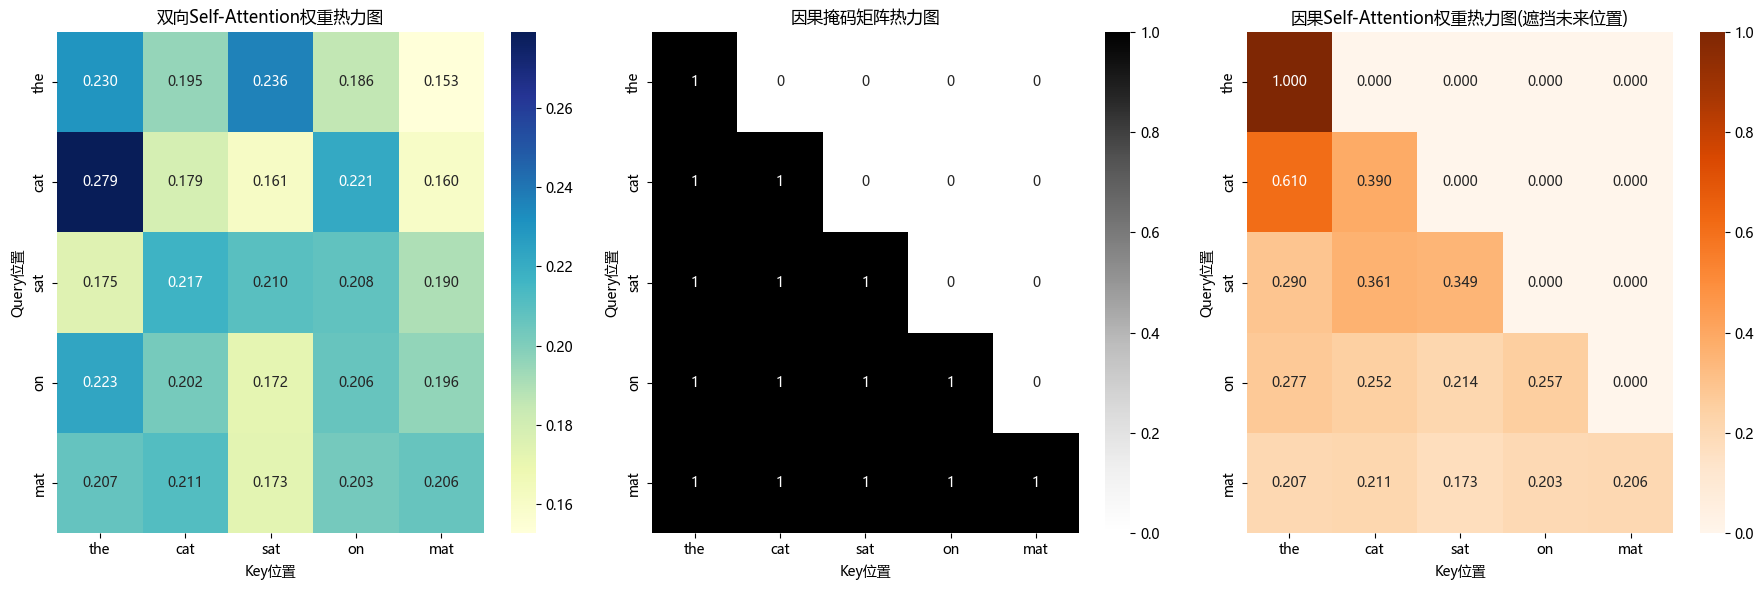

In [120]:
import matplotlib.pyplot as plt
import seaborn as sns

def _set_matplotlib_chinese_font() -> None:
    """Best-effort Chinese font setup to avoid missing glyph warnings."""
    try:
        from matplotlib import rcParams, font_manager
    except Exception:
        return

    installed = {f.name for f in font_manager.fontManager.ttflist}
    preferred = [
        'Microsoft YaHei',
        'SimHei',
        'Microsoft JhengHei',
        'PingFang SC',
        'Noto Sans CJK SC',
        'Source Han Sans CN',
        'WenQuanYi Micro Hei',
    ]
    for name in preferred:
        if name in installed:
            rcParams['font.sans-serif'] = [name]
            rcParams['axes.unicode_minus'] = False
            break

_set_matplotlib_chinese_font()

W_bi = weights_bidirectional[0].detach().cpu().squeeze().numpy()  # (seq_len, seq_len)
W_causal = weights_causal[0].detach().cpu().squeeze().numpy()  # (seq_len, seq_len)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.heatmap(
    W_bi,
    xticklabels=tokens,
    yticklabels=tokens,
    annot=True,
    fmt='.3f',
    cmap='YlGnBu',
    ax=axes[0]
)
axes[0].set_title("双向Self-Attention权重热力图")
axes[0].set_xlabel("Key位置")
axes[0].set_ylabel("Query位置")


sns.heatmap(
    cm[0,0].detach().cpu().numpy(),
    xticklabels=tokens,
    yticklabels=tokens,
    annot=True,
    fmt='.0f',
    cmap='Greys',
    ax=axes[1]
)
axes[1].set_title("因果掩码矩阵热力图")
axes[1].set_xlabel("Key位置")
axes[1].set_ylabel("Query位置")

sns.heatmap(
    W_causal,
    xticklabels=tokens,
    yticklabels=tokens,
    annot=True,
    fmt='.3f',
    cmap='Oranges',
    ax=axes[2])
axes[2].set_title("因果Self-Attention权重热力图(遮挡未来位置)")
axes[2].set_xlabel("Key位置")
axes[2].set_ylabel("Query位置")

plt.tight_layout()
plt.show()

In [121]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        """
            初始化多头注意力层
        
        :param self: Description
        :param d_model: Description
        :param num_heads: Description
        """
        assert d_model % num_heads == 0, "d_model必须能被num_heads整除"
        super(MultiHeadAttention, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads # 每个头的维度
        self.d_v = d_model // num_heads # 每个头的维度

        self.dropout = nn.Dropout(dropout)

        # 初始化线性变换层
        self.W_Q = nn.Linear(d_model, d_model, bias=False)
        self.W_K = nn.Linear(d_model, d_model, bias=False)
        self.W_V = nn.Linear(d_model, d_model, bias=False)
        self.W_O = nn.Linear(d_model, d_model, bias=False)

        nn.init.xavier_uniform_(self.W_Q.weight)
        nn.init.xavier_uniform_(self.W_K.weight)
        nn.init.xavier_uniform_(self.W_V.weight)
        nn.init.xavier_uniform_(self.W_O.weight)

    def forward(self, query, key, value, mask=None):
        """
        前向传播（兼容 self-attn / cross-attn 两种调用方式）
        
        用法：
          - Self-Attention:  mha(X, mask) 或 mha(X, mask=mask)
          - Cross-Attention: mha(X_q, X_kv, mask=src_mask)
        
        参数：
          - X_q: (B, L_q, d_model)
          - X_kv_or_mask: (B, L_kv, d_model) 或 mask 张量
          - mask: 广播到 (B, num_heads, L_q, L_kv) 的 0/1 掩码
        """


        B, L_q, _ = query.size()
        _, L_kv, _ = key.size()

        # 线性变换并分割成多个头
        Q = self.W_Q(query).view(B, L_q, self.num_heads, self.d_k).transpose(1, 2)  # (B, num_heads, L_q, d_k)
        K = self.W_K(key).view(B, L_kv, self.num_heads, self.d_k).transpose(1, 2)  # (B, num_heads, L_kv, d_k)
        V = self.W_V(value).view(B, L_kv, self.num_heads, self.d_v).transpose(1, 2)  # (B, num_heads, L_kv, d_v)

        # 计算缩放点积注意力
        attention, weights = scaled_dot_product_attention(Q, K, V, mask=mask)

        # 合并多个头的输出
        attention = attention.transpose(1, 2).contiguous().view(B, L_q, self.d_model)  # (B, L_q, d_model)

        # 最后的线性变换
        output = self.W_O(attention)  # (B, L_q, d_model)

        return output, weights

In [122]:
# 举个栗子
B = 2
sentence = ["The", "cat", "sat", "on", "the", "mat"]
seq_len = len(sentence)
d_model = 64 # 嵌入维度
d_k = d_v = 32 # 注意力维度
num_heads = 8

# # ===============================
# # 构造长序列（只为分析 attention）
# # ===============================
# seq_len = 32   # 🔥 改成 64 也可以

# # 用 [MASK] 作为占位 token（最干净、稳定）
# sentence = ["[MASK]"] * seq_len

# inputs = tokenizer(
#     sentence,
#     is_split_into_words=True,
#     return_tensors="pt",
#     add_special_tokens=False
# )

# with torch.no_grad():
#     X = bert.embeddings(
#         input_ids=inputs["input_ids"]
#     )

# tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
# print("Number of tokens:", len(tokens))
# # ===============================

# 随机初始化词嵌入（实际中会使用预训练的嵌入）
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert = BertModel.from_pretrained("bert-base-uncased")
bert.eval()
for p in bert.parameters():
    p.requires_grad = False
inputs = tokenizer(
    sentence,
    is_split_into_words=True,
    return_tensors="pt",
    add_special_tokens=False  # 不加 [CLS], [SEP]
)
with torch.no_grad():
    X = bert.embeddings(
        input_ids=inputs["input_ids"]
    )

tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
print(tokens)
print("Number of tokens:", len(tokens))

proj = nn.Linear(768, d_model)
X = proj(X)
print(f"输入X形状:{X.shape}")  # (B, L, d_model)

mha = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
# 双向注意力（不使用掩码）
attention_bidirectional, weights_bidirectional = mha(X, X, X, mask=None)
# 因果注意力（使用因果掩码）
L = X.size(1)
cm = causal_mask(L, device=X.device)
attention_causal, weights_causal = mha(X, X, X, mask=cm)
print(f"双向注意力输出形状:{attention_bidirectional.shape}")
print(f"因果注意力输出形状:{attention_causal.shape}")
print(f"双向注意力权重形状:{weights_bidirectional.shape}")
print(f"因果注意力权重形状:{weights_causal.shape}")


['the', 'cat', 'sat', 'on', 'the', 'mat']
Number of tokens: 6
输入X形状:torch.Size([1, 6, 64])
双向注意力输出形状:torch.Size([1, 6, 64])
因果注意力输出形状:torch.Size([1, 6, 64])
双向注意力权重形状:torch.Size([1, 8, 6, 6])
因果注意力权重形状:torch.Size([1, 8, 6, 6])


In [123]:
# 不同头的注意力权重分析
for i in range(mha.num_heads):
    weights = weights_causal[:, i, :, :]  # (B, L, L)
    print(f"\n头 {i+1} 因果注意力权重:\n{weights}")


头 1 因果注意力权重:
tensor([[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.5212, 0.4788, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.3038, 0.3089, 0.3873, 0.0000, 0.0000, 0.0000],
         [0.2591, 0.2549, 0.2497, 0.2363, 0.0000, 0.0000],
         [0.1737, 0.1956, 0.2404, 0.2002, 0.1902, 0.0000],
         [0.1799, 0.1788, 0.1646, 0.1321, 0.1796, 0.1651]]],
       grad_fn=<SliceBackward0>)

头 2 因果注意力权重:
tensor([[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.3935, 0.6065, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.3256, 0.3046, 0.3699, 0.0000, 0.0000, 0.0000],
         [0.2916, 0.2193, 0.2327, 0.2564, 0.0000, 0.0000],
         [0.2154, 0.1813, 0.1932, 0.1892, 0.2208, 0.0000],
         [0.1519, 0.1923, 0.1811, 0.1512, 0.1533, 0.1701]]],
       grad_fn=<SliceBackward0>)

头 3 因果注意力权重:
tensor([[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.4465, 0.5535, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.3044, 0.4103, 0.2853, 0.0000, 0.0000, 0.0000],
   

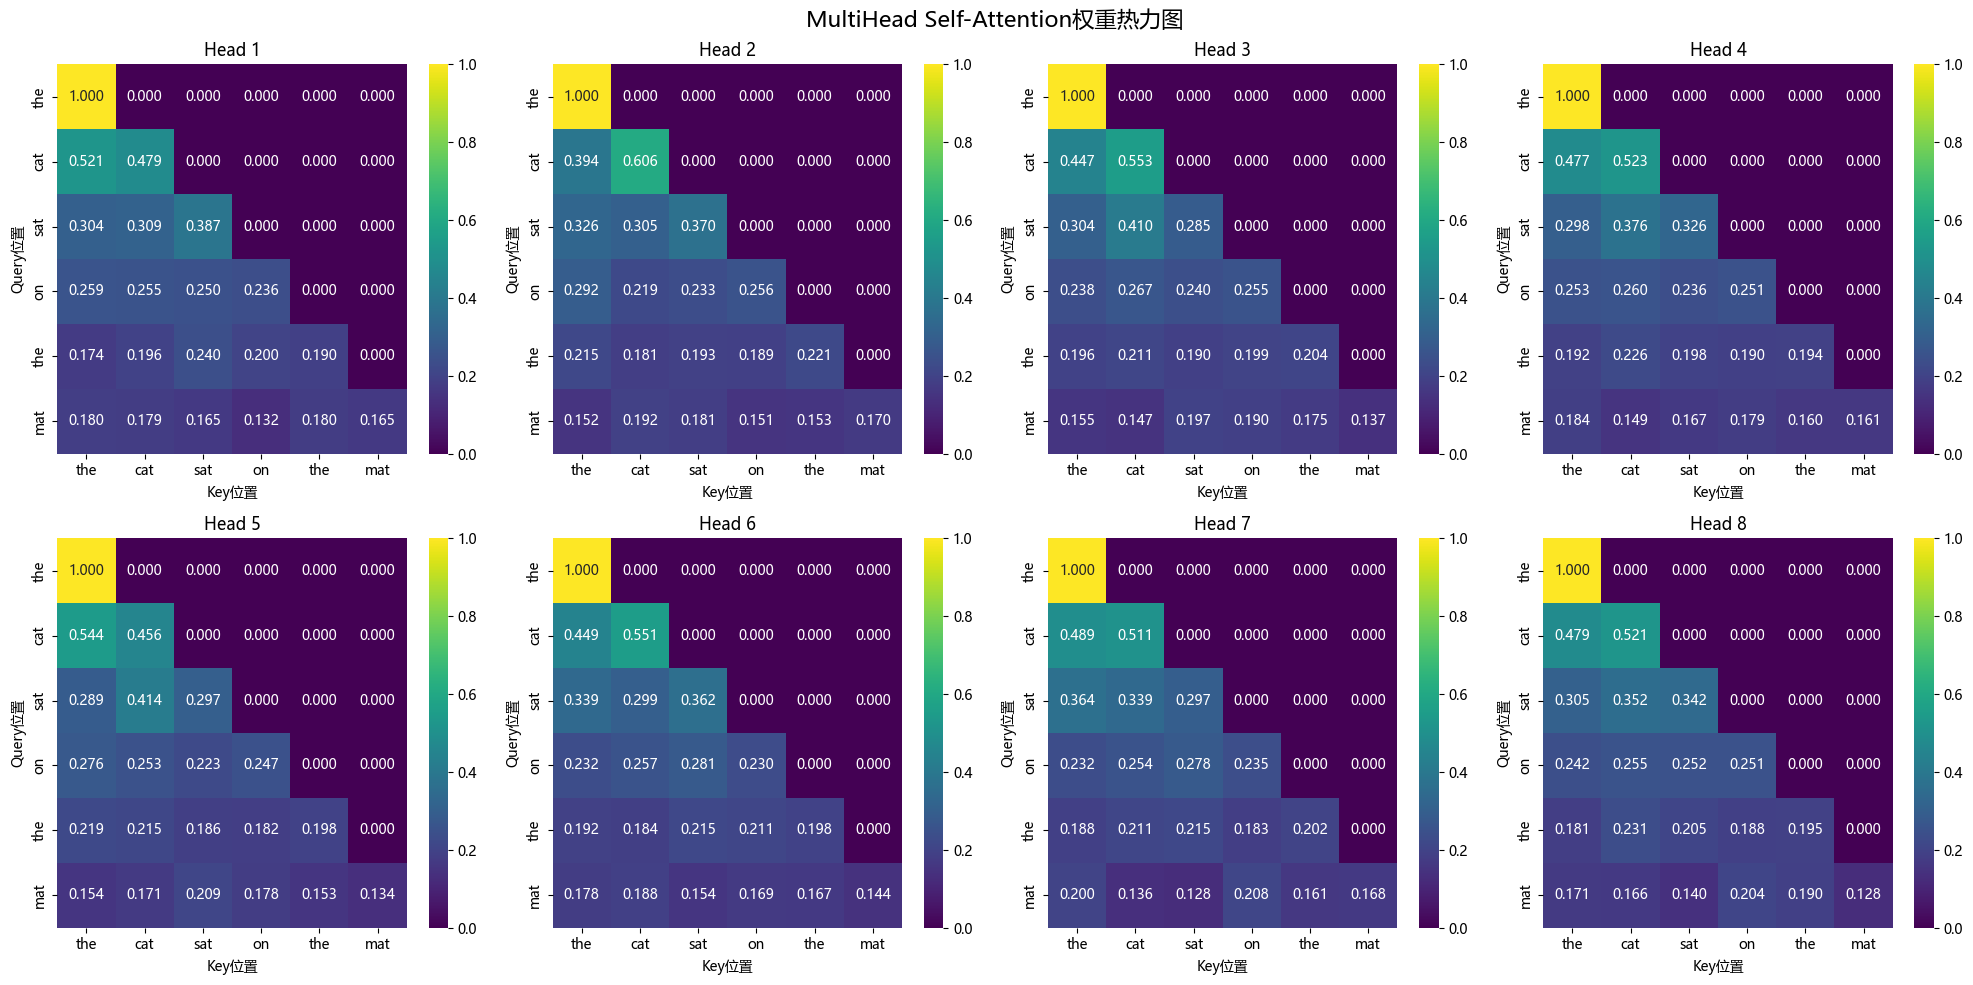

In [124]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i in range(num_heads):
    sns.heatmap(
        weights_causal[0, i].detach().cpu().numpy(),
        xticklabels=tokens,
        yticklabels=tokens,
        annot=True,
        fmt='.3f',
        cmap='viridis',
        ax=axes[i]
    )
    axes[i].set_title(f"Head {i+1}")
    axes[i].set_xlabel("Key位置")
    axes[i].set_ylabel("Query位置")
plt.suptitle("MultiHead Self-Attention权重热力图", fontsize=16)
plt.tight_layout()
plt.show()

In [125]:
import numpy as np

entropy_list = []
diag_weight_list = []

print("\n====== 不同 Attention Head 的模式分析（因果注意力） ======")

for i in range(num_heads):
    # 取第 0 个 batch 的第 i 个 head
    w = weights_causal[0, i].detach().cpu().numpy()  # (L, L)

    # 1. 自注意力强度（对角线）
    diag_weight = np.mean(np.diag(w))
    diag_weight_list.append(diag_weight)

    # 2. 熵（逐 query 计算，再平均）
    row_entropy = -np.sum(w * np.log(w + 1e-10), axis=-1)
    entropy = np.mean(row_entropy)
    entropy_list.append(entropy)

    # 3. 最大注意力位置
    max_pos = np.unravel_index(np.argmax(w), w.shape)

    print(
        f"Head {i+1}: "
        f"自注意力={diag_weight:.3f}, "
        f"熵={entropy:.3f}, "
        f"最大关注(query={max_pos[0]}, key={max_pos[1]})"
    )


====== 不同 Attention Head 的模式分析（因果注意力） ======
Head 1: 自注意力=0.410, 熵=1.093, 最大关注(query=0, key=0)
Head 2: 自注意力=0.437, 熵=1.090, 最大关注(query=0, key=0)
Head 3: 自注意力=0.406, 熵=1.092, 最大关注(query=0, key=0)
Head 4: 自注意力=0.409, 熵=1.095, 最大关注(query=0, key=0)
Head 5: 自注意力=0.389, 熵=1.091, 最大关注(query=0, key=0)
Head 6: 自注意力=0.414, 熵=1.094, 最大关注(query=0, key=0)
Head 7: 自注意力=0.402, 熵=1.093, 最大关注(query=0, key=0)
Head 8: 自注意力=0.406, 熵=1.093, 最大关注(query=0, key=0)


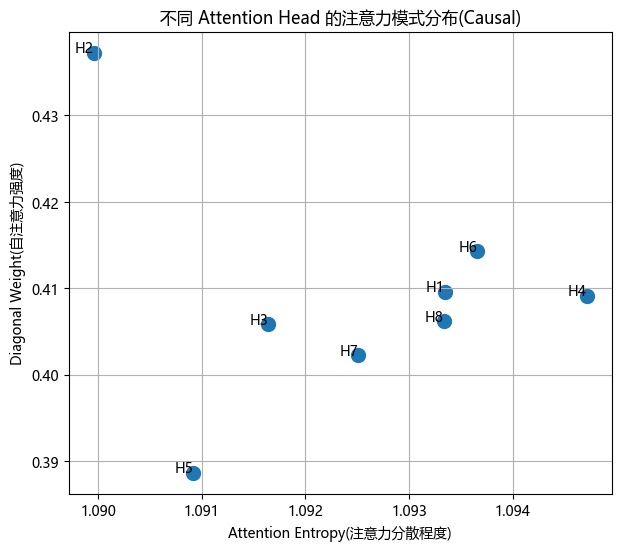

In [126]:
plt.figure(figsize=(7, 6))

plt.scatter(entropy_list, diag_weight_list, s=100)

for i in range(num_heads):
    plt.text(
        entropy_list[i],
        diag_weight_list[i],
        f"H{i+1}",
        fontsize=10,
        ha='right'
    )

plt.xlabel("Attention Entropy(注意力分散程度)")
plt.ylabel("Diagonal Weight(自注意力强度)")
plt.title("不同 Attention Head 的注意力模式分布(Causal)")

plt.grid(True)
plt.show()

# Cross-Attention:交叉注意力
Cross-Attention 是一种特殊的注意力机制，其中Query来自一个序列，而Key和Value来自另一序列。这使得模型能够在两个不同的序列之间建立关联。

|特性            |Self-Attention      |Cross-Attention|
|---------------|---------------------|---------------|
|Query来源       |序列X               |    序列X(目标) |
|Key/Value来源   |序列X               |     序列Y(源)  |
|关系类型        |序列内部             |    序列之间       |
|典型应用        |特征提取             |    序列对齐、融合 |


给定目标序列$X \in \mathbb{R}^{n \times d}$ 和源序列 $Y \in \mathbb{R}^{m \times d}$: 

$Q = X W^Q, K= X W^K, V = X W^V$ 

$Cross-Attention(X,Y) = softmax(\frac{Q K^T}{\sqrt{d_k}})V$

In [127]:
class CrossAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        """
            初始化多头交叉注意力层
        """
        assert d_model % num_heads == 0, "d_model必须能被num_heads整除"
        super(CrossAttention, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads # 每个头的维度
        self.d_v = d_model // num_heads # 每个头的维度

        # 初始化线性变换层
        self.W_Q = nn.Linear(d_model, d_model, bias=False)
        self.W_K = nn.Linear(d_model, d_model, bias=False)
        self.W_V = nn.Linear(d_model, d_model, bias=False)
        self.W_O = nn.Linear(d_model, d_model, bias=False)

        nn.init.xavier_uniform_(self.W_Q.weight)
        nn.init.xavier_uniform_(self.W_K.weight)
        nn.init.xavier_uniform_(self.W_V.weight)
        nn.init.xavier_uniform_(self.W_O.weight)
    
    def forward(self, X_q, X_kv, mask=None):
        """
        前向传播
        
        :param self: Description
        :param X_q: (B, L_q, d_model) 查询张量
        :param X_kv: (B, L_kv, d_model) 键值张量
        :param mask: (L_q, L_kv) 可选掩码张量
        :return: 多头交叉注意力输出和权重
        """

        B, L_q, _ = X_q.size()
        L_kv = X_kv.size(1)

        # 线性变换并分割成多个头
        Q = self.W_Q(X_q).view(B, L_q, self.num_heads, self.d_k).transpose(1, 2)  # (B, num_heads, L_q, d_k)
        K = self.W_K(X_kv).view(B, L_kv, self.num_heads, self.d_k).transpose(1, 2)  # (B, num_heads, L_kv, d_k)
        V = self.W_V(X_kv).view(B, L_kv, self.num_heads, self.d_v).transpose(1, 2)  # (B, num_heads, L_kv, d_v)

        # 计算缩放点积注意力
        attention, weights = scaled_dot_product_attention(Q, K, V, mask=mask)

        # 合并多个头的输出
        attention = attention.transpose(1, 2).contiguous().view(B, L_q, self.d_model)  # (B, L_q, d_model)

        # 最后的线性变换
        output = self.W_O(attention)  # (B, L_q, d_model)

        return output, weights

src tokens: ['the', 'cat', 'sat', 'on', 'the', 'mat']
tgt tokens: ['le', 'chat', 'est', 'ass', '##is', 'sur', 'le', 'tap', '##is']
encoder_output shape: torch.Size([1, 6, 64])
decoder_input shape: torch.Size([1, 9, 64])
cross_out shape: torch.Size([1, 9, 64])
cross_weights shape: torch.Size([1, 8, 9, 6])


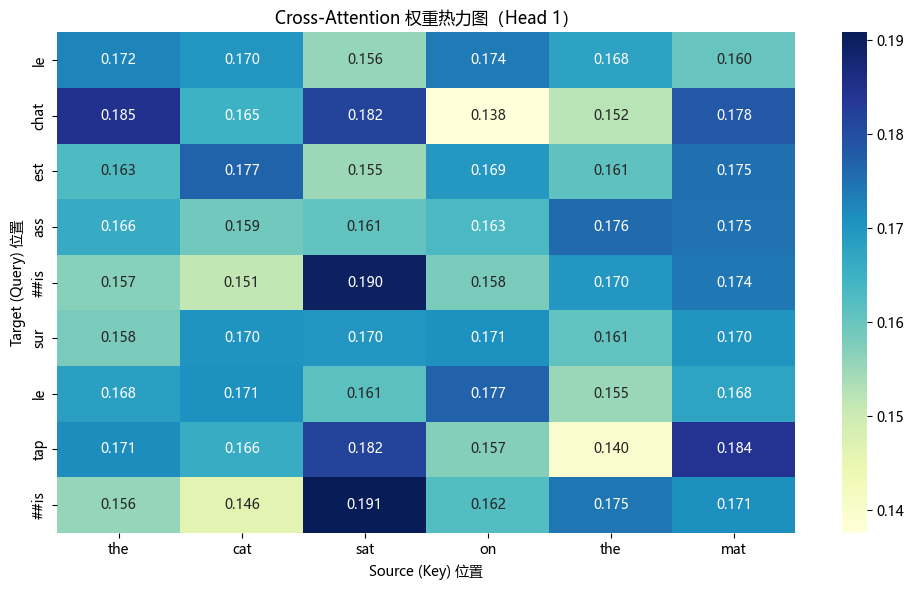

In [128]:
# 源序列（英语）
source_sentence = ["The", "cat", "sat", "on", "the", "mat"]
source_len = len(source_sentence)
# 目标序列（法语）
# target_sentence = ["Le", "chat", "s'est", "assis", "sur", "le", "tapis"]
target_sentence = ["Le", "chat", "est", "assis", "sur", "le", "tapis"]
target_len = len(target_sentence)

d_model = 64  # 嵌入维度
num_heads = 8

# ============ 1) 准备 source/target 的向量表示 ============
# 这里仿照前面 self-attention 的做法，用 BERT 的 embedding 当作“词向量”示例。
from transformers import BertTokenizer, BertModel

if 'tokenizer' not in globals():
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
if 'bert' not in globals():
    bert = BertModel.from_pretrained("bert-base-uncased")
    bert.eval()
    for p in bert.parameters():
        p.requires_grad = False

inputs_src = tokenizer(
    source_sentence,
    is_split_into_words=True,
    return_tensors="pt",
    add_special_tokens=False,
 )
inputs_tgt = tokenizer(
    target_sentence,
    is_split_into_words=True,
    return_tensors="pt",
    add_special_tokens=False,
 )

with torch.no_grad():
    src_embed_768 = bert.embeddings(input_ids=inputs_src["input_ids"])  # (B, L_src, 768)
    tgt_embed_768 = bert.embeddings(input_ids=inputs_tgt["input_ids"])  # (B, L_tgt, 768)

# 把 768 投影到 d_model，便于和我们手写的 attention 模块对齐
proj = nn.Linear(768, d_model)
encoder_output = proj(src_embed_768)  # (B, L_src, d_model)
decoder_input = proj(tgt_embed_768)   # (B, L_tgt, d_model)

src_tokens = tokenizer.convert_ids_to_tokens(inputs_src["input_ids"][0])
tgt_tokens = tokenizer.convert_ids_to_tokens(inputs_tgt["input_ids"][0])

print("src tokens:", src_tokens)
print("tgt tokens:", tgt_tokens)
print("encoder_output shape:", encoder_output.shape)
print("decoder_input shape:", decoder_input.shape)

# ============ 2) Cross-Attention（交叉注意力） ============
# Q 来自目标序列（decoder_input），K/V 来自源序列（encoder_output）
cross_attn = CrossAttention(d_model=d_model, num_heads=num_heads)

# 交叉注意力通常会对 source 侧做 padding mask；这里示例里不做 padding，mask=None 即可。
cross_out, cross_weights = cross_attn(X_q=decoder_input, X_kv=encoder_output, mask=None)

print("cross_out shape:", cross_out.shape)            # (B, L_tgt, d_model)
print("cross_weights shape:", cross_weights.shape)    # (B, num_heads, L_tgt, L_src)

# ============ 3) 可视化：画第 1 个 head 的 cross-attention 权重 ============
import matplotlib.pyplot as plt
import seaborn as sns

w0 = cross_weights[0, 0].detach().cpu().numpy()  # (L_tgt, L_src)
plt.figure(figsize=(10, 6))
sns.heatmap(
    w0,
    xticklabels=src_tokens,
    yticklabels=tgt_tokens,
    annot=True,
    fmt='.3f',
    cmap='YlGnBu'
 )
plt.title("Cross-Attention 权重热力图（Head 1）")
plt.xlabel("Source (Key) 位置")
plt.ylabel("Target (Query) 位置")
plt.tight_layout()
plt.show()

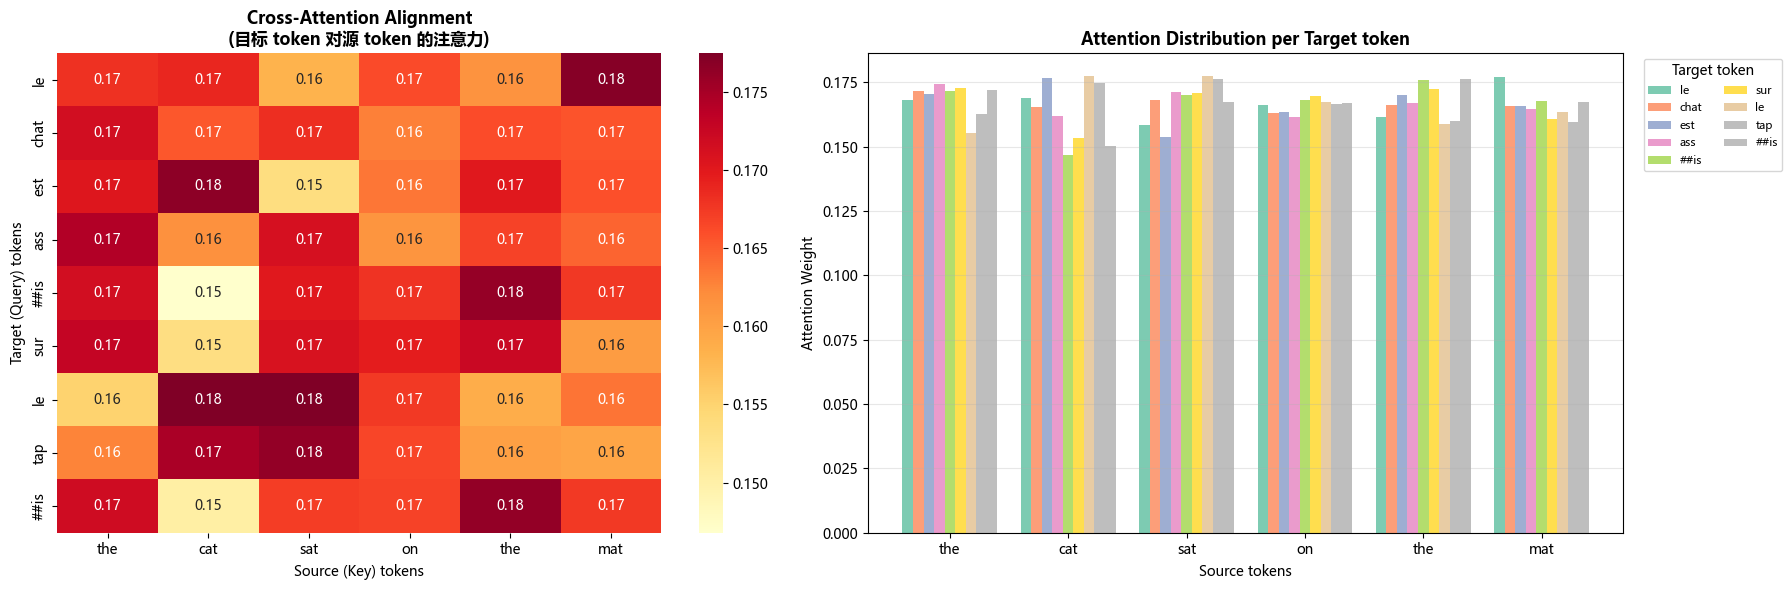

Cross-Attention 对齐分析（按 target token）:
  'le' 最关注 'mat' (权重: 0.177)
  'chat' 最关注 'the' (权重: 0.172)
  'est' 最关注 'cat' (权重: 0.177)
  'ass' 最关注 'the' (权重: 0.174)
  '##is' 最关注 'the' (权重: 0.176)
  'sur' 最关注 'the' (权重: 0.173)
  'le' 最关注 'sat' (权重: 0.177)
  'tap' 最关注 'sat' (权重: 0.176)
  '##is' 最关注 'the' (权重: 0.176)


In [129]:
# ============ 类似“对齐分析”的可视化（Cross-Attention Alignment） ============
# 这里直接复用上面单样本 cross-attention 的输出：cross_weights (B, heads, L_tgt, L_src)
# 为了更稳定，默认对所有 head 取平均得到一个 (L_tgt, L_src) 的对齐矩阵。

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

assert 'cross_weights' in globals(), "请先运行上面的 Cross-Attention 示例，生成 cross_weights"
assert 'src_tokens' in globals() and 'tgt_tokens' in globals(), "请先运行上面的 Cross-Attention 示例，生成 src_tokens/tgt_tokens"

# (L_tgt, L_src) 交叉注意力对齐矩阵：对 head 求均值
cross_attention_weights = cross_weights[0].mean(dim=0).detach().cpu().numpy()

source_labels = src_tokens
target_labels = tgt_tokens
source_len = len(source_labels)
target_len = len(target_labels)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 1) Cross-Attention 对齐热力图
sns.heatmap(
    cross_attention_weights,
    annot=True,
    fmt='.2f',
    cmap='YlOrRd',
    xticklabels=source_labels,
    yticklabels=target_labels,
    ax=axes[0]
 )
axes[0].set_title('Cross-Attention Alignment\n(目标 token 对源 token 的注意力)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Source (Key) tokens')
axes[0].set_ylabel('Target (Query) tokens')

# 2) 每个目标 token 的注意力分布（按 source 维度画柱状）
colors = plt.cm.Set2(np.linspace(0, 1, target_len))
x = np.arange(source_len)
width = min(0.8 / max(target_len, 1), 0.15)

for i, (tok, color) in enumerate(zip(target_labels, colors)):
    axes[1].bar(
        x + i * width,
        cross_attention_weights[i],
        width,
        label=f'{tok}',
        color=color,
        alpha=0.85,
    )

axes[1].set_xticks(x + width * (target_len - 1) / 2)
axes[1].set_xticklabels(source_labels)
axes[1].set_xlabel('Source tokens')
axes[1].set_ylabel('Attention Weight')
axes[1].set_title('Attention Distribution per Target token', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
axes[1].legend(title='Target token', fontsize=8, ncol=2, bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.show()

print('Cross-Attention 对齐分析（按 target token）:')
for i, tgt_tok in enumerate(target_labels):
    max_source_idx = int(np.argmax(cross_attention_weights[i]))
    max_weight = float(cross_attention_weights[i, max_source_idx])
    print(f"  '{tgt_tok}' 最关注 '{source_labels[max_source_idx]}' (权重: {max_weight:.3f})")

In [130]:
# ============ 4) Cross-Attention 的 source padding mask 示例 ============
# 真实 Transformer 里：encoder 端通常有 padding（对齐 batch），decoder cross-attn 需要 mask 掉 PAD。

# 构造一个 batch：两个 source 句子长度不同，让 tokenizer 自动 padding。
source_batch = [
    ["The", "cat", "sat", "on", "the", "mat"],  # 长句
    ["The", "cat", "sat"],                        # 短句，会被 padding
 ]
target_batch = [
    target_sentence,  # 目标序列这里用同一个（也可以不同）
    target_sentence,
 ]

inputs_src_pad = tokenizer(
    source_batch,
    is_split_into_words=True,
    return_tensors="pt",
    add_special_tokens=False,
    padding=True,
 )
inputs_tgt_pad = tokenizer(
    target_batch,
    is_split_into_words=True,
    return_tensors="pt",
    add_special_tokens=False,
    padding=True,
 )

print("inputs_src_pad input_ids shape:", inputs_src_pad["input_ids"].shape)
print("inputs_src_pad attention_mask:\n", inputs_src_pad["attention_mask"])

with torch.no_grad():
    src_embed_768_pad = bert.embeddings(input_ids=inputs_src_pad["input_ids"])  # (B, L_src_max, 768)
    tgt_embed_768_pad = bert.embeddings(input_ids=inputs_tgt_pad["input_ids"])  # (B, L_tgt_max, 768)

proj_pad = nn.Linear(768, d_model)
encoder_output_pad = proj_pad(src_embed_768_pad)  # (B, L_src_max, d_model)
decoder_input_pad = proj_pad(tgt_embed_768_pad)   # (B, L_tgt_max, d_model)

# source padding mask: (B, 1, 1, L_src_max)；1 表示保留，0 表示 PAD 位置需要遮挡
src_padding_mask = inputs_src_pad["attention_mask"].unsqueeze(1).unsqueeze(2).to(dtype=torch.int64)
print("src_padding_mask shape:", src_padding_mask.shape)

cross_attn_pad = CrossAttention(d_model=d_model, num_heads=num_heads)
cross_out_pad, cross_weights_pad = cross_attn_pad(
    X_q=decoder_input_pad,
    X_kv=encoder_output_pad,
    mask=src_padding_mask,
 )

print("cross_weights_pad shape:", cross_weights_pad.shape)  # (B, heads, L_tgt_max, L_src_max)

# 看看第二条样本（短句）对应的被 padding 的 source 列，权重应该接近 0
src_tokens_pad_0 = tokenizer.convert_ids_to_tokens(inputs_src_pad["input_ids"][0])
src_tokens_pad_1 = tokenizer.convert_ids_to_tokens(inputs_src_pad["input_ids"][1])
tgt_tokens_pad_0 = tokenizer.convert_ids_to_tokens(inputs_tgt_pad["input_ids"][0])

print("src_tokens_pad_0:", src_tokens_pad_0)
print("src_tokens_pad_1:", src_tokens_pad_1)

inputs_src_pad input_ids shape: torch.Size([2, 6])
inputs_src_pad attention_mask:
 tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 0]])
src_padding_mask shape: torch.Size([2, 1, 1, 6])
cross_weights_pad shape: torch.Size([2, 8, 9, 6])
src_tokens_pad_0: ['the', 'cat', 'sat', 'on', 'the', 'mat']
src_tokens_pad_1: ['the', 'cat', 'sat', '[PAD]', '[PAD]', '[PAD]']


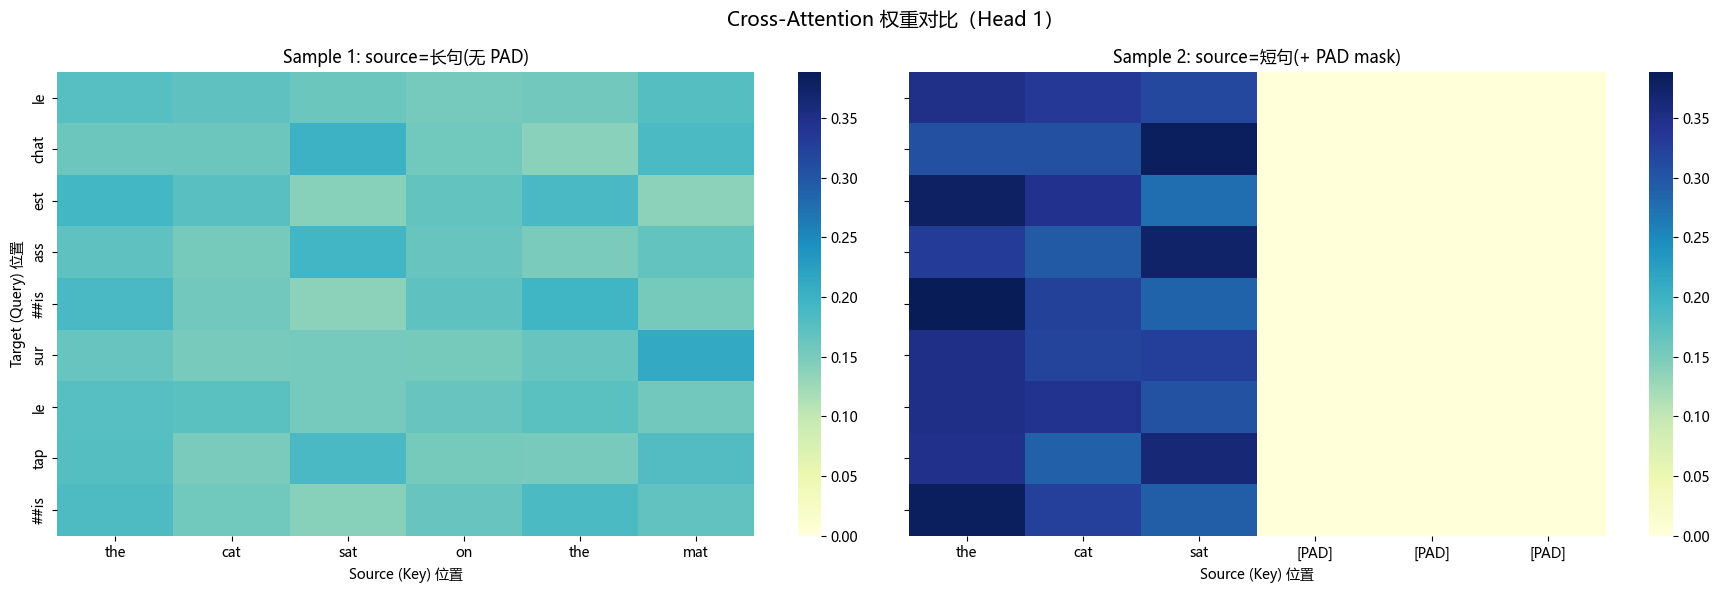

In [131]:
# ============ 5) 两个样本并排可视化对比 ============
# 对比 sample=1(长句) vs sample=2(短句+PAD)，看 PAD 列是否被压到接近 0

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

head_idx = 0  # Head 1
w_pad_0 = cross_weights_pad[0, head_idx].detach().cpu().numpy()  # (L_tgt_max, L_src_max)
w_pad_1 = cross_weights_pad[1, head_idx].detach().cpu().numpy()  # (L_tgt_max, L_src_max)

# 统一色标，方便肉眼对比
vmin = 0.0
vmax = float(np.max([w_pad_0.max(), w_pad_1.max()]))

tgt_tokens_pad_1 = tokenizer.convert_ids_to_tokens(inputs_tgt_pad["input_ids"][1])

fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
sns.heatmap(
    w_pad_0,
    xticklabels=src_tokens_pad_0,
    yticklabels=tgt_tokens_pad_0,
    cmap='YlGnBu',
    vmin=vmin,
    vmax=vmax,
    ax=axes[0],
    cbar=True,
 )
axes[0].set_title("Sample 1: source=长句(无 PAD)")
axes[0].set_xlabel("Source (Key) 位置")
axes[0].set_ylabel("Target (Query) 位置")

sns.heatmap(
    w_pad_1,
    xticklabels=src_tokens_pad_1,
    yticklabels=tgt_tokens_pad_1,
    cmap='YlGnBu',
    vmin=vmin,
    vmax=vmax,
    ax=axes[1],
    cbar=True,
 )
axes[1].set_title("Sample 2: source=短句(+ PAD mask)")
axes[1].set_xlabel("Source (Key) 位置")
axes[1].set_ylabel("")

plt.suptitle("Cross-Attention 权重对比（Head 1）", fontsize=14)
plt.tight_layout()
plt.show()

模拟翻译任务的注意力对齐可视化

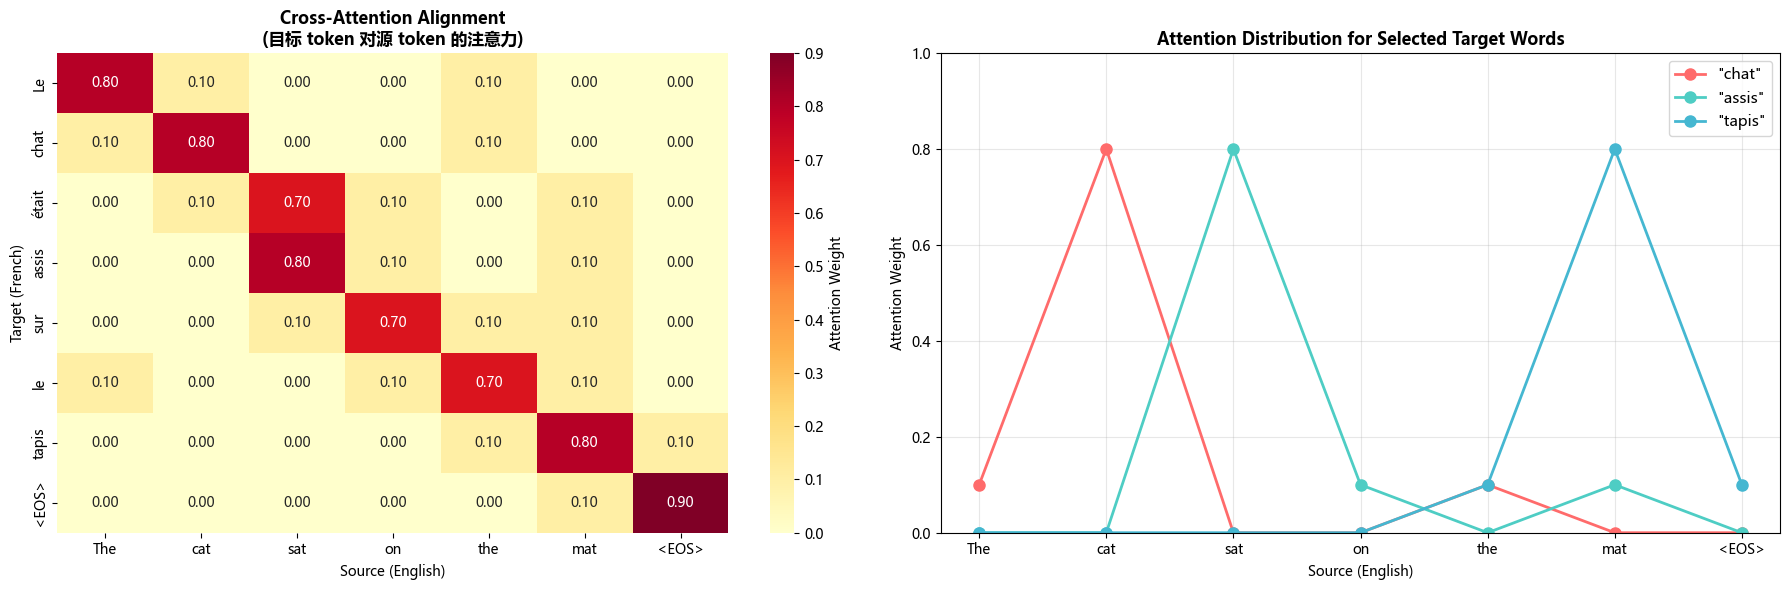

In [132]:
source_sentence = ["The", "cat", "sat", "on", "the", "mat", "<EOS>"]
target_sentence = ["Le", "chat", "était", "assis", "sur", "le", "tapis", "<EOS>"]

# 模拟注意力权重， 这里手动创建一个合理的对齐矩阵，使用 numpy 数组表示
attention_matrix = np.array([
    [0.8, 0.1, 0.0, 0.0, 0.1, 0.0, 0.0],  # Le -> The
    [0.1, 0.8, 0.0, 0.0, 0.1, 0.0, 0.0],  # chat -> cat
    [0.0, 0.1, 0.7, 0.1, 0.0, 0.1, 0.0],  # était -> sat
    [0.0, 0.0, 0.8, 0.1, 0.0, 0.1, 0.0],  # assis -> sat
    [0.0, 0.0, 0.1, 0.7, 0.1, 0.1, 0.0],  # sur -> on
    [0.1, 0.0, 0.0, 0.1, 0.7, 0.1, 0.0],  # le -> the
    [0.0, 0.0, 0.0, 0.0, 0.1, 0.8, 0.1],  # tapis -> mat
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.9],  # <EOS> -> <EOS>
])
import matplotlib.pyplot as plt
import seaborn as sns
# 可视化注意力对齐
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 1. 注意力热力图
sns.heatmap(
    attention_matrix,
    annot=True,
    fmt='.2f',
    cmap='YlOrRd',
    xticklabels=source_sentence,
    yticklabels=target_sentence,
    ax=axes[0],
    cbar_kws={"label": "Attention Weight"}
)
axes[0].set_title('Cross-Attention Alignment\n(目标 token 对源 token 的注意力)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Source (English)')
axes[0].set_ylabel('Target (French)')

# 2. 注意力分布（选择几个目标词）
target_words_to_plot = [1, 3, 6] # chat, assis, tapis
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for idx, (word_idx, color) in enumerate(zip(target_words_to_plot, colors)):
    axes[1].plot(attention_matrix[word_idx], 'o-', linewidth=2, markersize=8,
                label=f'"{target_sentence[word_idx]}"', color=color)
axes[1].set_xticks(np.arange(len(source_sentence)))
axes[1].set_xticklabels(source_sentence)
axes[1].set_xlabel('Source (English)')
axes[1].set_ylabel('Attention Weight')
axes[1].set_title('Attention Distribution for Selected Target Words', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.show()

注意力对齐分析:

- 'chat' (cat) 主要关注源句中的 'cat'

- 'assis' (sitting) 主要关注源句中的 'sat'

- 'tapis' (mat) 主要关注源句中的 'mat'

这展示了注意力机制如何自动学习源语言和目标语言之间的对齐关系(当然这里是手动给的注意力权重矩阵)

### FeedForward Network

In [133]:
class FeedForward(nn.Module):
    """
        两层线性变换,中间使用ReLU (或 GELU) 激活
    """
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)


    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

In [134]:
class EncoderLayer(nn.Module):
    """"
        单个Transformer Encoder层
        包含: Multi-Head Self-Attention + FFN, 每个子层有残差连接和LayerNorm
    """
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()

        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.ffn = FeedForward(d_model, d_ff, dropout)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        attention, weights = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout1(attention))

        # FFN子层
        ffn_output = self.ffn(x)
        x = self.norm2(x + self.dropout2(ffn_output))

        return x, weights

In [135]:
class Encoder(nn.Module):
    """
        Transformer Encoder
        由多个EncoderLayer堆叠而成
    """
    def __init__(self, num_layers, vocab_size, d_model, num_heads, d_ff, max_len=5000, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len)

        self.layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x, mask=None):
        # 词嵌入 + 位置编码
        x = self.embedding(x) * math.sqrt(self.d_model) # 缩放嵌入
        x = self.pos_encoding(x)

        all_weights = []
        for layer in self.layers:
            x, weights = layer(x, mask)
            all_weights.append(weights)
        x = self.norm(x)
        
        return x, all_weights

In [136]:
class DecoderLayer(nn.Module):
    """
        单个Transformer Decoder层
        包含: Masked Multi-Head Self-Attention + Multi-Head Cross-Attention + FFN
        每个子层有残差连接和LayerNorm
    """
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()

        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.cross_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.ffn = FeedForward(d_model, d_ff, dropout)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask=None, tgt_mask=None):
        # Masked Self-Attention
        self_attention, self_weights = self.self_attn(x, x, x, mask=tgt_mask)
        x = self.norm1(x + self.dropout1(self_attention))

        # Cross-Attention
        cross_attention, cross_weights = self.cross_attn(x, enc_output, enc_output, mask=src_mask)
        x = self.norm2(x + self.dropout2(cross_attention))

        # FFN子层
        ffn_output = self.ffn(x)
        x = self.norm3(x + self.dropout3(ffn_output))

        return x, self_weights, cross_weights

In [137]:
class Decoder(nn.Module):
    """
        Transformer Decoder
        由多个DecoderLayer堆叠而成
    """
    def __init__(self, num_layers, vocab_size, d_model, num_heads, d_ff, max_len=5000, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len)

        self.layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x, enc_output, src_mask=None, tgt_mask=None):
        # 词嵌入 + 位置编码
        x = self.embedding(x) * math.sqrt(self.d_model) # 缩放嵌入
        x = self.pos_encoding(x)

        all_self_weights = []
        all_cross_weights = []
        for layer in self.layers:
            x, self_weights, cross_weights = layer(x, enc_output, src_mask, tgt_mask)
            all_self_weights.append(self_weights)
            all_cross_weights.append(cross_weights)
        x = self.norm(x)
        
        return x, all_self_weights, all_cross_weights

完整的Transformer实现与训练

In [138]:
class Transformer(nn.Module):
    """
    完整的Transformer模型（Encoder-Decoder架构）
    
    用于序列到序列任务，如机器翻译
    """
    
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=512, num_heads=8, 
                 d_ff=2048, num_encoder_layers=6, num_decoder_layers=6, 
                 max_len=5000, dropout=0.1):
        super().__init__()
        
        self.encoder = Encoder(
            num_layers=num_encoder_layers,
            vocab_size=src_vocab_size,
            d_model=d_model,
            num_heads=num_heads,
            d_ff=d_ff,
            max_len=max_len,
            dropout=dropout,
        )
        self.decoder = Decoder(
            num_layers=num_decoder_layers,
            vocab_size=tgt_vocab_size,
            d_model=d_model,
            num_heads=num_heads,
            d_ff=d_ff,
            max_len=max_len,
            dropout=dropout,
        )
        
        # 最终的线性层，将d_model映射到目标词表大小
        self.output_projection = nn.Linear(d_model, tgt_vocab_size)
        
        # 初始化参数
        self._init_parameters()
        
    def _init_parameters(self):
        """Xavier初始化"""
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
                
    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        # Encoder
        encoder_output, _ = self.encoder(src, src_mask)
        
        # Decoder（Decoder 返回: x, all_self_weights, all_cross_weights）
        decoder_output, _, _ = self.decoder(tgt, encoder_output, src_mask, tgt_mask)
        
        # 输出投影
        logits = self.output_projection(decoder_output)
        
        return logits
    
    def encode(self, src, src_mask=None):
        """仅编码（用于推理）"""
        return self.encoder(src, src_mask)[0]
    
    def decode(self, tgt, encoder_output, src_mask=None, tgt_mask=None):
        """仅解码（用于推理）"""
        decoder_output, _, _ = self.decoder(tgt, encoder_output, src_mask, tgt_mask)
        return self.output_projection(decoder_output)


# 创建完整的Transformer模型
print("=== 完整Transformer模型 ===\n")

src_vocab_size = 10000  # 源语言词表大小
tgt_vocab_size = 10000  # 目标语言词表大小
d_model = 512
num_heads = 8
d_ff = 2048
num_layers = 6

model = Transformer(
    src_vocab_size=src_vocab_size,
    tgt_vocab_size=tgt_vocab_size,
    d_model=d_model,
    num_heads=num_heads,
    d_ff=d_ff,
    num_encoder_layers=num_layers,
    num_decoder_layers=num_layers
)

# 统计参数
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"模型配置:")
print(f"  d_model: {d_model}")
print(f"  num_heads: {num_heads}")
print(f"  d_ff: {d_ff}")
print(f"  num_layers: {num_layers}")
print(f"\n参数统计:")
print(f"  总参数: {total_params:,}")
print(f"  可训练参数: {trainable_params:,}")
print(f"  模型大小: {total_params * 4 / 1024 / 1024:.2f} MB (float32)")

=== 完整Transformer模型 ===

模型配置:
  d_model: 512
  num_heads: 8
  d_ff: 2048
  num_layers: 6

参数统计:
  总参数: 59,473,680
  可训练参数: 59,473,680
  模型大小: 226.87 MB (float32)


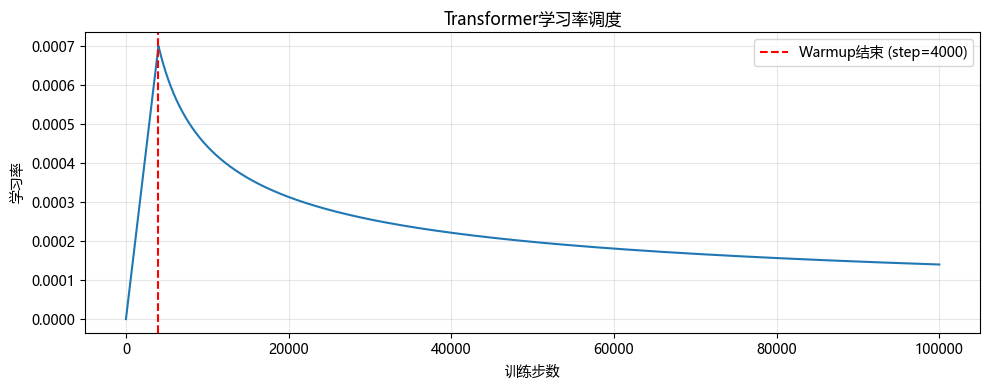

Warmup阶段: 0 → 4000 步
峰值学习率: 0.000699
最终学习率: 0.000140


In [139]:
# 学习率调度
class TransformerLRScheduler:
    """
    Transformer学习率调度器
    
    lr = d_model^(-0.5) * min(step^(-0.5), step * warmup_steps^(-1.5))
    """
    
    def __init__(self, optimizer, d_model, warmup_steps=4000):
        self.optimizer = optimizer
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        self.step_num = 0
        
    def step(self):
        self.step_num += 1
        lr = self._get_lr()
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
        return lr
    
    def _get_lr(self):
        step = self.step_num
        return self.d_model ** (-0.5) * min(step ** (-0.5), step * self.warmup_steps ** (-1.5))


# 可视化学习率调度
def visualize_lr_schedule(d_model=512, warmup_steps=4000, total_steps=100000):
    """可视化Transformer学习率调度曲线"""
    steps = np.arange(1, total_steps + 1)
    lrs = d_model ** (-0.5) * np.minimum(steps ** (-0.5), steps * warmup_steps ** (-1.5))
    
    plt.figure(figsize=(10, 4))
    plt.plot(steps, lrs)
    plt.axvline(x=warmup_steps, color='r', linestyle='--', label=f'Warmup结束 (step={warmup_steps})')
    plt.xlabel('训练步数')
    plt.ylabel('学习率')
    plt.title('Transformer学习率调度')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('diagrams/lr_schedule.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"Warmup阶段: 0 → {warmup_steps} 步")
    print(f"峰值学习率: {lrs[warmup_steps-1]:.6f}")
    print(f"最终学习率: {lrs[-1]:.6f}")

visualize_lr_schedule()

=== 训练演示 ===

Step 20: Loss = 6.9840
Step 40: Loss = 6.9539
Step 60: Loss = 6.9587
Step 80: Loss = 6.9616
Step 100: Loss = 6.9288


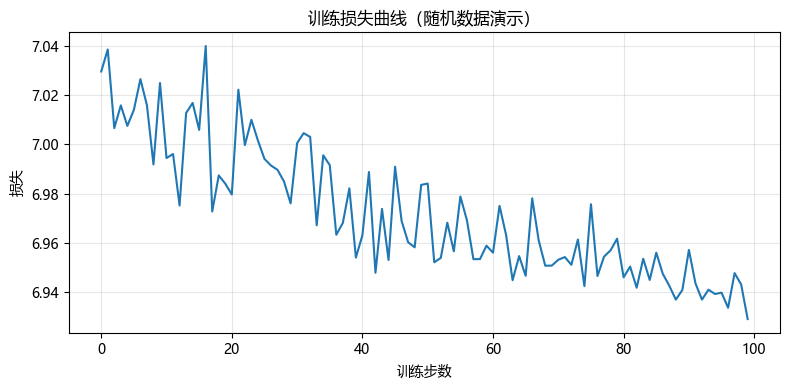

In [140]:
# Transformer模型训练示例
def train_step(model, src, tgt, optimizer, criterion, scheduler=None):
    """
    单步训练
    
    参数:
        model: Transformer模型
        src: 源序列 [batch_size, src_len]
        tgt: 目标序列 [batch_size, tgt_len]
        optimizer: 优化器
        criterion: 损失函数
        scheduler: 学习率调度器
    """
    model.train()
    optimizer.zero_grad()
    
    # 目标输入（去掉最后一个token）和目标标签（去掉第一个token）
    tgt_input = tgt[:, :-1]
    tgt_label = tgt[:, 1:]
    
    # 创建因果掩码
    tgt_mask = causal_mask(tgt_input.size(1), tgt_input.device)
    
    # 前向传播
    logits = model(src, tgt_input, tgt_mask=tgt_mask)
    
    # 计算损失
    loss = criterion(logits.reshape(-1, logits.size(-1)), tgt_label.reshape(-1))
    
    # 反向传播
    loss.backward()
    
    # 梯度裁剪（防止梯度爆炸）
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    
    optimizer.step()
    
    if scheduler:
        scheduler.step()
    
    return loss.item()


# 演示训练过程（使用随机数据）
print("=== 训练演示 ===\n")

# 创建小型模型用于演示
demo_model = Transformer(
    src_vocab_size=1000,
    tgt_vocab_size=1000,
    d_model=128,
    num_heads=4,
    d_ff=512,
    num_encoder_layers=2,
    num_decoder_layers=2
)

optimizer = torch.optim.Adam(demo_model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
criterion = nn.CrossEntropyLoss(ignore_index=0)  # 忽略padding token

# 模拟训练数据
batch_size = 32
src_len = 20
tgt_len = 25

losses = []
for step in range(100):
    # 生成随机数据
    src = torch.randint(1, 1000, (batch_size, src_len))
    tgt = torch.randint(1, 1000, (batch_size, tgt_len))
    
    loss = train_step(demo_model, src, tgt, optimizer, criterion)
    losses.append(loss)
    
    if (step + 1) % 20 == 0:
        print(f"Step {step + 1}: Loss = {loss:.4f}")

# 绘制损失曲线
plt.figure(figsize=(8, 4))
plt.plot(losses)
plt.xlabel('训练步数')
plt.ylabel('损失')
plt.title('训练损失曲线（随机数据演示）')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('diagrams/training_loss.png', dpi=150, bbox_inches='tight')
plt.show()

# Vision Transformer(ViT)
Transformer 不仅限于NLP，ViT将其应用于计算机视觉领域：

1. 将图像分割为固定大小的patch（如16x16）

2. 将每个patch线性投影为向量

3. 添加位置编码

4. 通过标准Transformer Encoder处理

![](https://assets.community.aws/a/2oWE98q6BziPvIgdeSts3ypVc46/Scre.webp?imgSize=4058x1636)